In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
time_slot = 5*60*1000 # 5 seconds
length = 10 # number of timeslots around
embedded_size = 30
N = 7

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/NCKH/IoT/dataset_17-02-2022.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/IoT/v4_lstm.hdf5'

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)
df['timestamp'] = list(map(lambda x: int(datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()),df['timestamp']))
df.head(10)

,sensor,value,timestamp
0,O3,0.20565482974052,1594028407
1,NO2,0,1594028407
2,CO,0.23644705116749,1594028407
3,PRES,100276.1875,1594028407
4,HUM,49.6015625,1594028407
5,TC,25.5,1594028407
6,BAT,58,1594028407
7,O3,0.20122393965721,1594030208
8,NO2,0,1594030208
9,CO,0.16477552056313,1594030208


In [ ]:
lst_sensor = list(set(df['sensor']))
lst_sensor.remove('WV')
len(lst_sensor)

16

In [ ]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1594027700, 1623141813, 98)

In [ ]:
import more_itertools as mit

X_idx = []
y = []

maximum_value = {}
start_end = {}
normalized_df = pd.DataFrame(columns=df.columns)

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]
  history = subdf.value.astype(np.float32)
  history[history < 0] = 0
  maximum_value[sensor] = np.max(history)
  y.extend(history[N:]/maximum_value[sensor])
  history = (history/maximum_value[sensor] * 100).astype(int)
  X_idx.extend(list(mit.windowed(history, n=N, step=1))[:-1])
  
  subdf.value = history
  normalized_df = normalized_df.append(subdf)

df = normalized_df
X = np.array(X_idx)
y = np.array(y)
X.shape, y.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


((486340, 7), (486340,))

In [ ]:
maximum_value

{'ANE': 40.79999923706055,
 'B': 45.0,
 'BAT': 100.0,
 'CO': 11.349579811096191,
 'HUM': 100.0,
 'LUX': 21010.0,
 'NO2': 0.17887425422668457,
 'NOISE': 73.00460052490234,
 'O3': 0.4146099388599396,
 'PLV1': 107.56999969482422,
 'PLV2': 46.380001068115234,
 'PLV3': 102.54000091552734,
 'PM10': 10.100000381469727,
 'PM25': 8.800000190734863,
 'PRES': 100939.109375,
 'TC': 43.7599983215332}

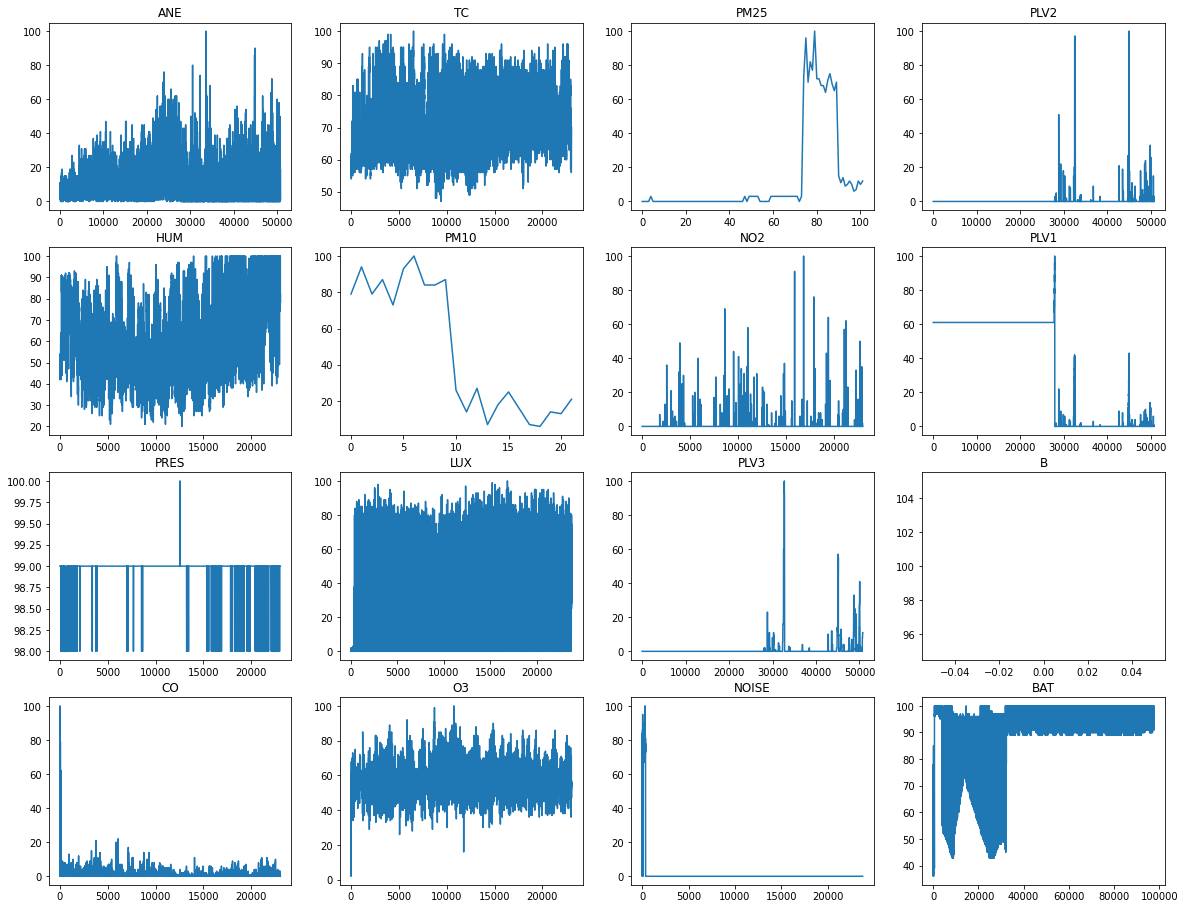

In [ ]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(20,20))

for i,sensor in enumerate(lst_sensor,start=1):
    yy = df[df.sensor==sensor].value
    xx = range(len(yy))
    
    f.add_subplot(5,4,i)
    plt.plot(xx,yy)
    plt.title(sensor)

### generate

In [ ]:
len(lst_sensor)

16

In [ ]:
import more_itertools as mit
from google.colab import output
from functools import reduce
X_item2vec = []
# X = []
# y = []

#is_exists = np.zeros(num_of_items,)

def onehot(x):
  #x: int
  lst = [0]*100
  lst[x] = 1
  return lst

def removeNul(x):
  #(1,2,-1,3,-1,2) -> (1,2,3,2)
  res = []
  return [str(i) for i in x if (i != -1)]

def flatten(x):
  #[[1],[2,1,3],[2]] -> [1,2,1,3,2]
  return [str(i) for c in x for i in c]

all_values = set()

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]

  # train_data for Item2Vec
  idx = ((subdf.timestamp - start_time) // time_slot).to_numpy()[:-1]
  values = subdf.value
  series = [[] for _ in range(num_of_slots)]
  for id,value in zip(idx,values):
    series[id].append(value)

  temp = list(mit.windowed(series, n=length, step=1))[:-1]  
  new_row = list(map(flatten,temp))
  X_item2vec.extend(new_row)
  
  for i in new_row: 
    all_values = all_values.union(i)


  # data for MLP
  # history = list(map(lambda x: hash_itemID[x],subdf.itemID))
  # new_x = list(mit.windowed(history, n=N, step=1))[:-1]
  # X.extend(new_x)
  # y.extend(list(map(onehot,history[N:])))

  # sensor = 'ANE'
  # X = np.array(X[start_end[sensor][0]:start_end[sensor][1]])
  # y = np.array(y[start_end[sensor][0]:start_end[sensor][1]])
  # y = y/100
  # X.shape, y.shape

In [ ]:
#######################################
# CHECK IF THIS VALUE IS EQUAL TO 101 #
#######################################
len(all_values)

101

In [ ]:
from gensim.models import Word2Vec
#CBOW model
vecs = Word2Vec(X_item2vec, min_count=1, size=embedded_size, window=5, sg=0)

In [ ]:
vecs['31']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.7230278 , -1.1956077 ,  1.0634019 , -0.0730032 , -2.6821554 ,
       -0.9376298 ,  1.1417204 , -1.3080256 ,  1.9077379 , -0.75486815,
       -1.9579505 ,  0.20044847, -1.2897964 , -0.47276133,  1.8530203 ,
        0.01635862, -2.3346117 , -0.81572586, -1.0599258 ,  0.08049514,
       -1.3206167 ,  1.4902924 ,  2.5195975 , -1.4844283 ,  0.9716674 ,
        1.8005635 , -1.1037335 ,  1.6924673 ,  1.0046008 ,  1.3859632 ],
      dtype=float32)

In [ ]:
vecs.similar_by_vector(vecs['31'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('31', 1.0),
 ('32', 0.8453099727630615),
 ('29', 0.8024488091468811),
 ('30', 0.7833055853843689),
 ('34', 0.7823838591575623),
 ('35', 0.7770013809204102),
 ('28', 0.7549858093261719),
 ('33', 0.7358988523483276),
 ('25', 0.6505200266838074),
 ('27', 0.6425862312316895)]

#### split train-test

In [ ]:
def mapping(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecs[str(i)] for i in x]

In [ ]:
X = np.array(list(map(mapping,X)))
y = np.array(y)
y = y.reshape(len(y), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
len(X) == len(X_train) + len(X_test) + len(X_val), len(y) == len(y_train) + len(y_test) + len(y_val)

(True, True)

In [ ]:
print(X_train[0],y_train[0],sep='\n\n')

[[ 2.005722    0.06573185  2.5591466  -0.11776756 -0.243516    3.4657562
  -0.9063669   1.9646562  -2.572672   -4.3361773  -1.1559672  -0.7781255
  -1.4053651  -5.0186343  -0.5045578  -1.866332   -2.571467    1.9617659
   1.4796019   2.028201    2.6744177  -2.5492983   0.6384355   1.2682625
  -0.8948084  -1.960894    1.3407466  -0.10414002 -0.33317676 -0.3953253 ]
 [ 2.005722    0.06573185  2.5591466  -0.11776756 -0.243516    3.4657562
  -0.9063669   1.9646562  -2.572672   -4.3361773  -1.1559672  -0.7781255
  -1.4053651  -5.0186343  -0.5045578  -1.866332   -2.571467    1.9617659
   1.4796019   2.028201    2.6744177  -2.5492983   0.6384355   1.2682625
  -0.8948084  -1.960894    1.3407466  -0.10414002 -0.33317676 -0.3953253 ]
 [ 2.005722    0.06573185  2.5591466  -0.11776756 -0.243516    3.4657562
  -0.9063669   1.9646562  -2.572672   -4.3361773  -1.1559672  -0.7781255
  -1.4053651  -5.0186343  -0.5045578  -1.866332   -2.571467    1.9617659
   1.4796019   2.028201    2.6744177  -2.549298

In [ ]:
X_train.shape, y_train.shape

((350164, 7, 30), (350164, 1))

# MLP

In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf 
from sklearn.metrics import mean_squared_error

model = Sequential()

model.add(InputLayer((N, embedded_size)))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
#input_raw = Input((N,embedded_size))
#flatten = Flatten()(hidden)
#hidden = LSTM(32, activation='relu')(input_raw)

#y_pred = Dense(1, activation='sigmoid')(hidden)

#model = Model(inputs = input_raw, outputs = y_pred)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                24320     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 24,385
Trainable params: 24,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lrate = 3e-4
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=opt, loss=root_mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=10, monitor='val_loss')
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=128,epochs=1000,verbose=True, callbacks=[early_stop,model_checkpoint])

Epoch 1/1000
2736/2736 [==============================] - 47s 16ms/step - loss: 0.0424 - root_mean_squared_error: 0.0483 - val_loss: 0.0378 - val_root_mean_squared_error: 0.0409
Epoch 2/1000
2736/2736 [==============================] - 45s 16ms/step - loss: 0.0377 - root_mean_squared_error: 0.0409 - val_loss: 0.0369 - val_root_mean_squared_error: 0.0400
Epoch 3/1000
2736/2736 [==============================] - 42s 16ms/step - loss: 0.0370 - root_mean_squared_error: 0.0402 - val_loss: 0.0364 - val_root_mean_squared_error: 0.0396
Epoch 4/1000
2736/2736 [==============================] - 43s 16ms/step - loss: 0.0366 - root_mean_squared_error: 0.0397 - val_loss: 0.0363 - val_root_mean_squared_error: 0.0395
Epoch 5/1000
2736/2736 [==============================] - 43s 16ms/step - loss: 0.0362 - root_mean_squared_error: 0.0393 - val_loss: 0.0362 - val_root_mean_squared_error: 0.0394
Epoch 6/1000
2736/2736 [==============================] - 43s 16ms/step - loss: 0.0360 - root_mean_squared_err

In [ ]:
model.save_weights(WEIGHTS_PATH)

Text(0.5, 1.0, 'lrate=0.0003')

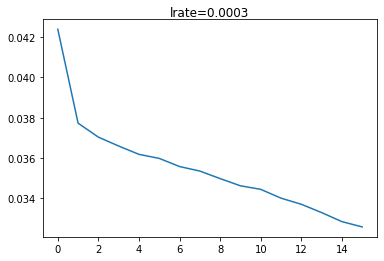

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.title('lrate='+str(lrate), pad=-50)

In [ ]:
model.load_weights(WEIGHTS_PATH)

In [ ]:
rmse_model = model.evaluate(X_test, y_test)
print("Mean Square Error of Model = {}".format(rmse_model))

3040/3040 [==============================] - 9s 3ms/step - loss: 0.0342 - root_mean_squared_error: 0.0438
Mean Square Error of Model = [0.03417249023914337, 0.04376421123743057]


In [ ]:
y_pred = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_pred, y_test))

print("MSE of testset = {}".format(rmse))

MSE of testset = 0.04376420810219848


In [ ]:
#wrapper
def process(sensor, inp):
  #sensor: sensor id
  #x: array/ndarray of N value in the past
  inp = (np.array(inp)/maximum_value[sensor]*100).astype(int)
  inp = np.array([vecs[str(i)] for i in inp])
  out = model.predict(np.array([inp]))
  out = out*maximum_value[sensor]

  return out[0][0]

## Infer

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)

idx = 33586
arr = df[df.sensor=='ANE'].value.to_numpy().astype(np.float32)
print("SAMPLE INPUT: ",end='')
print(', '.join(arr[idx:idx+N].astype(str)))
print("EXPECT: ",end='')
print(arr[idx+N])

SAMPLE INPUT: 2.4, 5.6, 3.2, 23.2, 15.2, 40.8, 4.0
EXPECT: 5.6


In [ ]:
process('ANE',arr[idx:idx+N])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


8.438238